In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import Adam
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
image_dir = Path('D:\\AIML\\FishImgClassificationProject\\Data\\train')
image_paths= list(image_dir.glob(r'**/*.jpg'))

# Get images and corresponding labels
images = [str(p) for p in image_paths]
labels = [os.path.split(os.path.split(p)[0])[1] for p in image_paths]

df = pd.DataFrame({'Image Path': images,'Label': labels})
print(df['Label'].unique())
print(df)

['animal fish' 'animal fish bass' 'fish sea_food black_sea_sprat'
 'fish sea_food gilt_head_bream' 'fish sea_food hourse_mackerel'
 'fish sea_food red_mullet' 'fish sea_food red_sea_bream'
 'fish sea_food sea_bass' 'fish sea_food shrimp'
 'fish sea_food striped_red_mullet' 'fish sea_food trout']
                                             Image Path                Label
0     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
1     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
2     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
3     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
4     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
...                                                 ...                  ...
6220  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6221  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6222  D:\A

In [6]:
df['Label'].value_counts()

Label
animal fish                         1096
fish sea_food trout                  580
fish sea_food red_mullet             579
fish sea_food shrimp                 576
fish sea_food hourse_mackerel        573
fish sea_food red_sea_bream          571
fish sea_food black_sea_sprat        569
fish sea_food gilt_head_bream        566
fish sea_food striped_red_mullet     547
fish sea_food sea_bass               538
animal fish bass                      30
Name: count, dtype: int64

In [7]:
# Sample 200 images from each class
samples = []

for category in df['Label'].unique():
    category_slice = df.query("Label == @category")
    if(category == 'animal fish bass'):
        samples.append(category_slice.sample(30, random_state=1))
    else:
        samples.append(category_slice.sample(200, random_state=1))
print(category)
print(category_slice)
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(df)

fish sea_food trout
                                             Image Path                Label
5645  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
5646  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
5647  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
5648  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
5649  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
...                                                 ...                  ...
6220  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6221  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6222  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6223  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6224  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout

[580 rows x 2 columns]
                                

In [ ]:
def plot_history(history):
    """ Plots the graph of Accuracy and Loss over epochs with the history of the model """

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1)) 
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()

In [ ]:
# Split the Fish image data into train and test

train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
# Preprocess/Data Augmentation of the train and test data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator( 
                                                                rescale=1./255,
                                                                shear_range=0.2, 
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                                                validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                rescale = 1./255,
                                                                preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
# Generate the train, validation and test images

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1137 validated image filenames belonging to 11 classes.
Found 284 validated image filenames belonging to 11 classes.
Found 609 validated image filenames belonging to 11 classes.


In [ ]:
# Load the pretrained ResNet50 model

pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


c:\Users\My Pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.0888 - loss: 2.3859 - val_accuracy: 0.0845 - val_loss: 2.3747
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.1047 - loss: 2.3369 - val_accuracy: 0.0599 - val_loss: 2.3807
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.1231 - loss: 2.3241 - val_accuracy: 0.0669 - val_loss: 2.3361
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.1557 - loss: 2.2815 - val_accuracy: 0.1514 - val_loss: 2.2291
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.1812 - loss: 2.2408 - val_accuracy: 0.1373 - val_loss: 2.2375


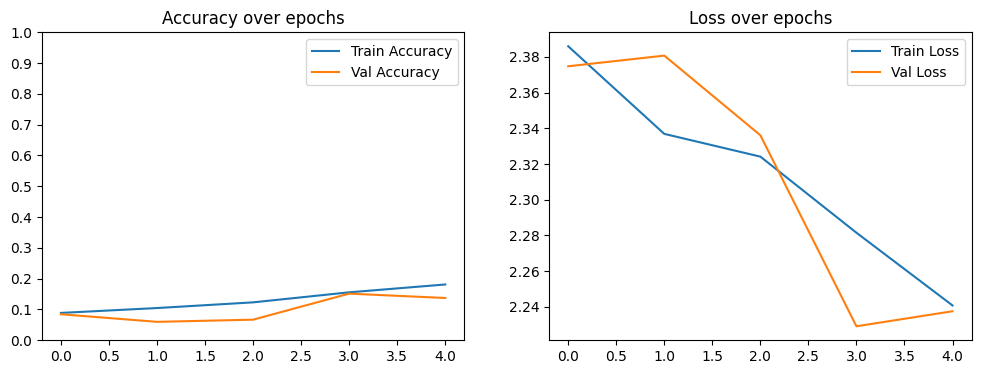

In [ ]:
# Build the ResNet50 model

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the ResNet50 model
model.compile(
    optimizer= Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the ResNet50 model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

# Plot graph for Accuracy and Loss over Epochs
plot_history(history)

In [ ]:
# Evaluate the ResNet50 model

results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 2.27586
Test Accuracy: 12.64%


In [ ]:
# Predict and display the metrics of the ResNet50 model

prediction_probs = model.predict(test_images)
predictions = np.argmax(prediction_probs, axis=1)

y_true = test_images.classes

print(f"Accuracy: {accuracy_score(y_true, predictions):.4f}")
print(f"Precision: {precision_score(y_true, predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_true, predictions, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_true, predictions, average='weighted'):.4f}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true, predictions)}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Accuracy: 0.1264
Precision: 0.0370
Recall: 0.1264
F1-Score: 0.0552
Confusion Matrix:
 [[36  0  0  0  0  0  9 17  0  0  0]
 [ 8  0  0  0  0  0  0  5  0  0  0]
 [19  0  0  0  0  0  0 45  0  0  0]
 [13  0  0  0  0  0  4 48  0  0  0]
 [ 5  0  0  0  0  0  0 60  0  0  0]
 [27  0  0  0  0  0 26 15  0  0  0]
 [12  0  0  0  0  0  9 25  0  0  0]
 [21  0  0  0  0  0  6 32  0  0  0]
 [36  0  0  0  0  0 10 15  0  0  0]
 [15  0  0  0  0  0  7 35  0  0  0]
 [ 8  0  0  0  0  0  1 40  0  0  0]]


c:\Users\My Pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
